# Demo 1: Typical ML pipeline

In this demo, we demonstrate a standard Machine Learning pipeline using the **network traffic classification** learning problem. We will demonstrate the pipeline's common steps to later discuss its problems and flaws.

## Learning Problem Description

We will take the role of an **Internet Service Provider**, whose task is to provide users with a qualitative Internet connection, including to different services and websites. To achieve this, providers often are required to **classify network traffic flows** to separate **video streams (e.g., Twitch)**, **communication service calls (like Zoom)**, **instant messaging apps**, and others.

These classification algorithms are often deployed on last-mile networks and require the corresponding data to train. 

In this scenario, we will train a classifier to classify the traffic of two popular video streaming platforms, **YouTube** and **Vimeo**, and also separate it from **other traffic**.

## Typical Machine Learning Pipeline definition

The classical Machine Learning pipeline consists of the following phases:

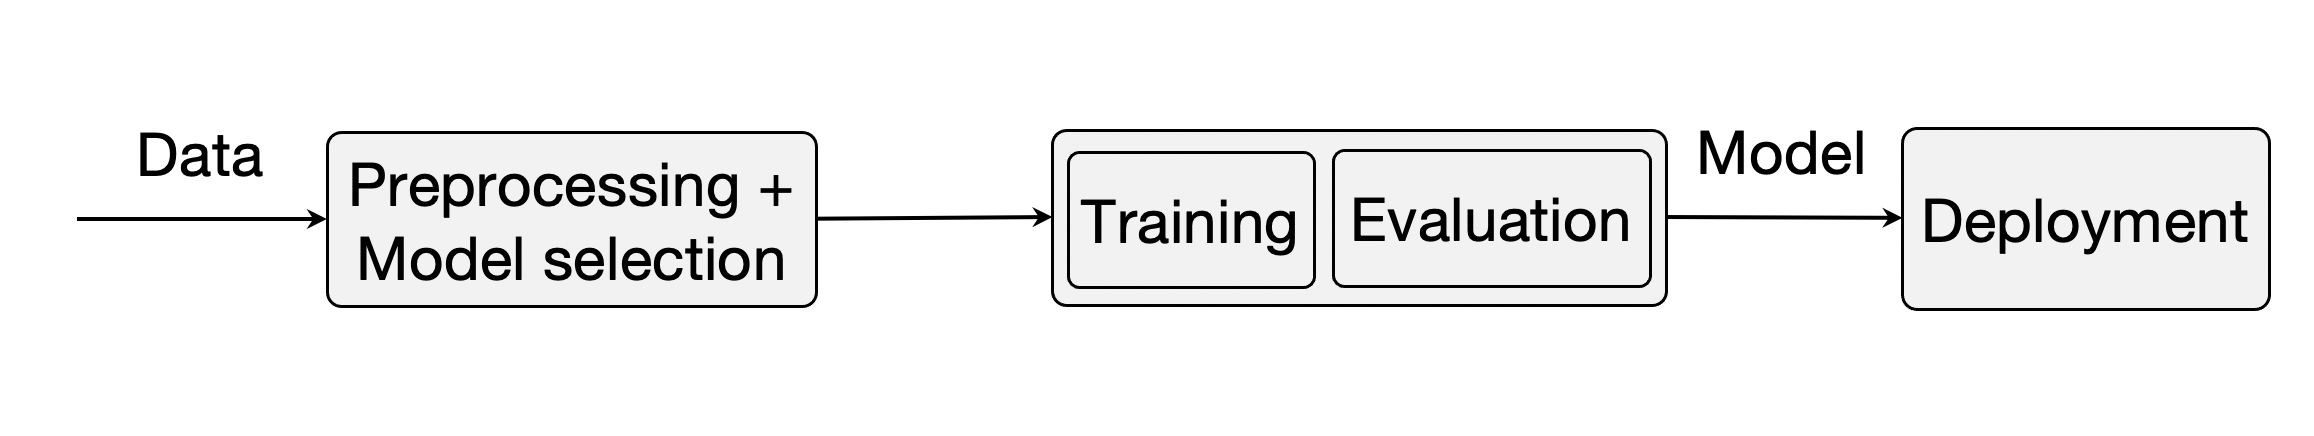

1. Data is given to the user and usually can be modified in place, but not recollected.
2. The Data Preprocessing step cleans the data, labels it, selects required features, and prepares it for Machine Learning algorithms.
3. The Model Selection step is required to correctly find a model (or models) to apply
4. During the Training and Evaluation steps, researchers train the corresponding models and evaluate their performance (usually on a separate test or validation dataset)
5. If the model shows good performance, the model is deployed to be used in production settings.


## Data description

For this demo, we collected a small dataset, containing **YouTube** and **Vimeo** network traffic corresponding to the same video clip, uploaded on these two platforms. The collected PCAP files with network traffic also contain other traffic, such as web page load, video previews, pictures, and other information.

The collected dataset is stored as PCAP files for YouTube and Vimeo traffic correspondingly.

## Data preprocessing: CICFlowMeter

To extract features usable by Machine Learning algorithms, we used the CICFlowMeter tool. This tool summarizes network flows in the given PCAP and provides network flow statistics, such as *Total Packets*, *Bytes/sec*, *Mean Inter-Arrival Time*, etc.

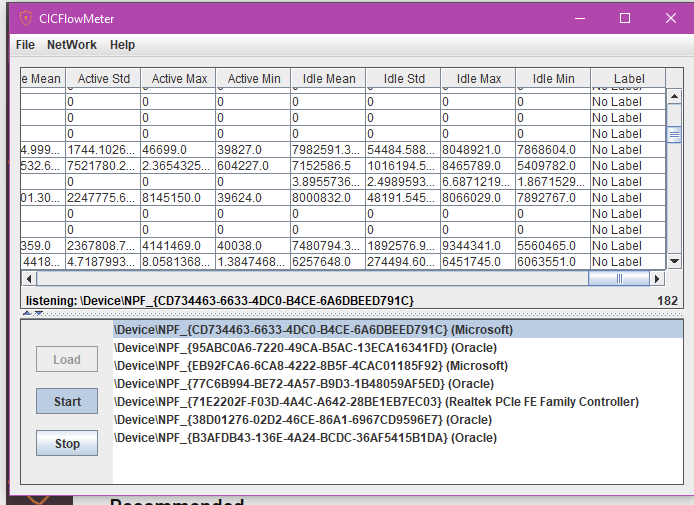

We preprocessed YouTube and Vimeo PCAP files into corresponding CSVs with all network flows information.

## Data preprocessing: Exploration

In this step, we will explore the data, extracted from PCAP files using CICFlowMeter.

In [ ]:
import pandas as pd
df_youtube = pd.read_csv("./capture_youtube.pcap_Flow.csv")
df_vimeo = pd.read_csv("./capture_vimeo.pcap_Flow.csv")

print(df_youtube.columns)   # these are all columns that CICFlowMeter uses

In [ ]:
df_youtube.head()

## Data preprocessing: labeling

In this scenario, we will use a simple labeling strategy to obtain ground truth labels for each flow of the dataset. As our data consists only of **video streams** and **other short traffic**, we will label each flow longer than 30 packets in any direction as a corresponding *video stream* flow, and all other flows - as *other*. 

In [ ]:
df_youtube['Label'] = 'other'
df_youtube.loc[(df_youtube['Total Fwd Packet'] > 30) | (df_youtube['Total Bwd packets'] > 30), 'Label'] = 'youtube'  

In [ ]:
df_vimeo['Label'] = 'other'
df_vimeo.loc[(df_vimeo['Total Fwd Packet'] > 30) | (df_vimeo['Total Bwd packets'] > 30), 'Label'] = 'vimeo'

## Data preprocessing step: cleaning and data preparation

We will also clean the dataset - remove features we don't want to use and rows with NaN values to avoid breaking Machine Learning algorithms. Afterward, we will split the data into training and testing datasets.

In [ ]:
df = pd.concat([df_youtube, df_vimeo], ignore_index=True)
df = df.drop(['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp'], axis=1)
df = df.dropna()  # remove rows with Nones

In [ ]:
target_variable = 'Label'
train_features = list(set(df.columns) - {target_variable})
X = df[train_features]
y = df[target_variable]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Model selection

As we need to **classify** network traffic, we will use popular classification algorithms for this task - Random Forest, Gradient Boosting, and Multi-Layer Perceptron. We will use and train all three of them to compare results and choose the best model for deployment.

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

In [ ]:
classifiers = [
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    MLPClassifier(),
]

## Model training

On this step, we will train each of the classifiers...

In [ ]:
for clf in classifiers:
    clf.fit(X_train, y_train)

## Model Evaluation
...and evaluate all of them using training and testing data separately.

In [ ]:
for clf in classifiers:
    print(clf)
    y_pred = clf.predict(X_train.values)
    print(metrics.classification_report(y_train, y_pred))
    print()

In [ ]:
for clf in classifiers:
    print(clf)
    y_pred = clf.predict(X_test.values)
    print(metrics.classification_report(y_test, y_pred))
    print()